# T-tests and boxplots of truncations in domains of PTEN in Endometrial 

This notebook creates a boxplot for the cis effect of PTEN truncations in the phosphatase domain and the C2 domain in Endometrial.

Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import gseapy as gp
import re
import sys 

import cptac
import cptac.utils as u

import plot_utils as p

In [24]:
# Step 1 - Create proteomics and truncations dataframe

def get_trunc_df(trunc_type, gene='PTEN'):
    prot_and_mutations = en.join_omics_to_mutations(
        mutations_genes = [gene], omics_df_name = 'proteomics', omics_genes = gene, 
        mutations_filter = [trunc_type]) 
    keep = [trunc_type,'Wildtype_Tumor']
    in_keep = prot_and_mutations['PTEN_Mutation'].isin(keep)
    trunc_mutations = prot_and_mutations[in_keep]
    print(trunc_mutations['PTEN_Mutation'].value_counts())

    # Step 2 - Create binary column 
    trunc_mutations['Mutation'] = np.where(
                trunc_mutations[gene+'_Mutation_Status'] == 'Wildtype_Tumor', 'Wildtype_Tumor', trunc_type)

    # Step 3 - Format the dataframe correctly for the t-test(just omics and binary columns for tumors)
    tumors = trunc_mutations[trunc_mutations.Sample_Status == 'Tumor'] #drop Normal samples
    columns_to_drop = [gene+"_Mutation", gene+"_Mutation_Status", "Sample_Status"]
    e_trunc_wt = tumors.drop(columns_to_drop, axis = 1)
    return e_trunc_wt

In [2]:
def format_pval_annotation(pval_symbol, x1, x2, line_start = .05, line_height=.05):
    # for manual adjustment to pval annotations
    
    y, h = line_start, line_height
    plt.plot([x1, x1, x2, x2], #draw horizontal line
             [y, y+h, y+h, y], #vertical line
             lw=1.5, color= '.3')
    plt.text((x1+x2)*.5, # half between x coord
             y+h, pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")


# Step 1: Create data frames with PTEN truncations mutation in a certain domain 

First, load in cancer data sets from cptac.

In [3]:
en = cptac.Endometrial()

# Create the df for Nonsense Mutations in the Phosphatase Domain

In [20]:
ns = get_trunc_df('Nonsense_Mutation') # df with wt and nonsense mut

Nonsense_Mutation    25
Wildtype_Tumor       20
Name: PTEN_Mutation, dtype: int64


cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 69 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 7)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


Create a df with only PTEN Wildtype_Tumor.

Create a df with only mutations located in the phosphatase domain. (Both domains effected by the mutation).

In [21]:
wt = ns.loc[ns['Mutation'] == 'Wildtype_Tumor']

In [23]:
# create new column with starting amino acid (aa) as an int
ns['aa'] = ns.apply(lambda x: (x['PTEN_Location']), axis=1)
df = ns.loc[ns['Mutation'] == 'Nonsense_Mutation']
df1 = df.replace({'aa': r'^p.[A-Z]*'}, {'aa': ''}, regex=True)
df2 = df1.replace({'aa': r'\*$'}, {'aa': ''}, regex=True)
df2['aa'] = pd.to_numeric(df2["aa"])

# Keep only mutations in the domain (cutoff aa = 185)
df_p = df2.loc[df2['aa'] <= 185]

# Merge wt and df with mutations in domain
p_wt = df_p.append(wt)
p_wt.head()

,PTEN_proteomics,PTEN_Location,Mutation,aa
Patient_ID,,,,
C3L-00032,-0.941,p.W111*,Nonsense_Mutation,111.0
C3L-00137,-1.010,p.Y180*,Nonsense_Mutation,180.0
C3L-00156,-1.590,p.E7*,Nonsense_Mutation,7.0
C3L-00586,-1.210,p.E7*,Nonsense_Mutation,7.0
C3L-00601,-1.180,p.E7*,Nonsense_Mutation,7.0


# Step 2: T-test 

In [12]:
# T-test
cols = ['PTEN_proteomics']
trunc_in_phos_pval = u.wrap_ttest(p_wt, 'Mutation', cols, return_all = True)
trunc_in_phos_pval

,Comparison,P_Value
0,PTEN_proteomics,0.000092


# Step 3: Plot

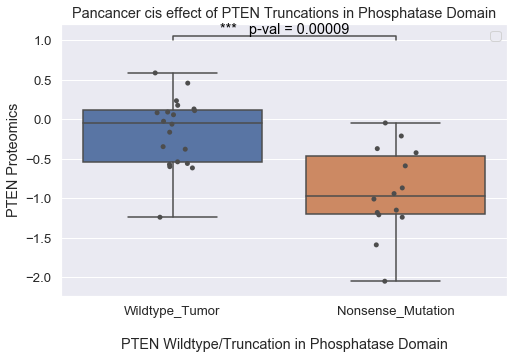

In [15]:
gene = 'PTEN'
plt.rcParams['figure.figsize']=(8,5) #size of plot
sns.set(font_scale = 1.2)

boxplot = sns.boxplot(x='Mutation', y=gene+"_proteomics", data = p_wt, 
                      order=['Wildtype_Tumor','Nonsense_Mutation'], showfliers = False)    
boxplot.set_title('Pancancer cis effect of PTEN Truncations in Phosphatase Domain')
boxplot = sns.stripplot(x='Mutation', y=gene+"_proteomics", data = p_wt,
                         order=['Wildtype_Tumor','Nonsense_Mutation'], jitter = True, 
                         color = ".3", dodge = True)
boxplot.set(xlabel = "\nPTEN Wildtype/Truncation in Phosphatase Domain", ylabel = gene+' Proteomics')

# format legend
handles, labels = boxplot.get_legend_handles_labels()
plt.legend(handles[0:3], labels[0:3])

# Create significance symbols:
# * P ≤ 0.05   ** P ≤ 0.01   *** P ≤ 0.001 
format_pval_annotation('***   p-val = 0.00009', 0, 1, 1)


plt.show()
plt.clf()
plt.close()

# Frame_Shift_Del

In [30]:
fsd = get_trunc_df('Frame_Shift_Del') # df with wt and nonsense mut

Frame_Shift_Del    24
Wildtype_Tumor     20
Name: PTEN_Mutation, dtype: int64


cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 69 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 6)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [42]:
# create new column with starting amino acid (aa) as an int
fsd['aa'] = fsd.apply(lambda x: (x['PTEN_Location']), axis=1)
df = fsd.loc[fsd['Mutation'] == 'Frame_Shift_Del']
df1 = df.replace({'aa': r'^p.[A-Z]*'}, {'aa': ''}, regex=True)
df2 = df1.replace({'aa': r'\*$'}, {'aa': ''}, regex=True)
df2 = df2.replace({'aa': r'[A-Z]fs\*\d*$'}, {'aa': ''}, regex=True)
df2['aa'] = pd.to_numeric(df2["aa"])
df2.head()

Name,PTEN_proteomics,PTEN_Location,Mutation,aa
Patient_ID,,,,
C3L-00161,-1.040,p.K267Rfs*9,Frame_Shift_Del,267
C3L-00413,-1.700,p.N262Qfs*35,Frame_Shift_Del,262
C3L-00767,-1.110,p.T321Kfs*22,Frame_Shift_Del,321
C3L-00769,-0.219,p.N12Tfs*12,Frame_Shift_Del,12
C3L-00780,0.291,p.G293Efs*14,Frame_Shift_Del,293


In [43]:
# Keep only mutations in the domain (cutoff aa = 190)
df_p = df2.loc[df2['aa'] >= 190]

# Merge wt and df with mutations in domain
p_wt = df_p.append(wt)
p_wt.head()

,PTEN_proteomics,PTEN_Location,Mutation,aa
Patient_ID,,,,
C3L-00161,-1.040,p.K267Rfs*9,Frame_Shift_Del,267.0
C3L-00413,-1.700,p.N262Qfs*35,Frame_Shift_Del,262.0
C3L-00767,-1.110,p.T321Kfs*22,Frame_Shift_Del,321.0
C3L-00780,0.291,p.G293Efs*14,Frame_Shift_Del,293.0
C3L-00781,-0.700,p.K267Rfs*9,Frame_Shift_Del,267.0


In [44]:
# T-test
cols = ['PTEN_proteomics']
trunc_in_phos_pval = u.wrap_ttest(p_wt, 'Mutation', cols, return_all = True)
trunc_in_phos_pval

,Comparison,P_Value
0,PTEN_proteomics,0.005895


In [ ]:
plt.rcParams['figure.figsize']=(8,5) #size of plot
sns.set(font_scale = 1.2)

boxplot = sns.boxplot(x='Mutation', y=gene+"_proteomics", data = p_wt, 
                      order=['Wildtype_Tumor','Nonsense_Mutation'], showfliers = False)    
boxplot.set_title('Pancancer cis effect of PTEN Truncations in Phosphatase Domain')
boxplot = sns.stripplot(x='Mutation', y=gene+"_proteomics", data = p_wt,
                         order=['Wildtype_Tumor','Nonsense_Mutation'], jitter = True, 
                         color = ".3", dodge = True)
boxplot.set(xlabel = "\nPTEN Wildtype/Truncation in Phosphatase Domain", ylabel = gene+' Proteomics')

# format legend
handles, labels = boxplot.get_legend_handles_labels()
plt.legend(handles[0:3], labels[0:3])

# Create significance symbols:
# * P ≤ 0.05   ** P ≤ 0.01   *** P ≤ 0.001 
format_pval_annotation('***   p-val = 0.00009', 0, 1, 1)


plt.show()
plt.clf()
plt.close()